In [1]:
# CHECK IF RUNNING INSIDE GOOGLE.COLAB

import sys
import os

IN_COLAB = 'google.colab' in sys.modules
CLONED = 0
if IN_COLAB and not CLONED:
    # clone the repo
    !git clone https://github.com/technogleb/ts_walkthrough
    CLONED = 1
    # append to sys.path
    sys.path.append('/content/ts_walkthrough')
    # change working directory to project root
    os.chdir('/content/ts_walkthrough')
    # install requirements
    !pip install -r requirements.txt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

from dataset import Dataset
import plotting

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dataset = Dataset('./data/dataset')

In [7]:
ts = dataset['alcohol_sales.csv']
ts.index = ts.index.map(pd.to_datetime)

In [8]:
ts, ts_test = ts[:250], ts[250:]

<AxesSubplot: xlabel='0'>

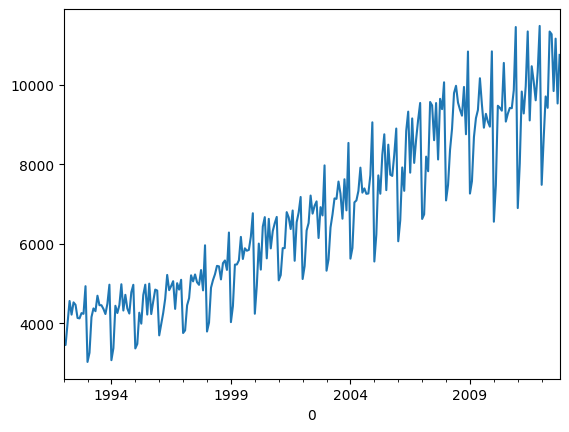

In [9]:
ts.plot()

#### Задание 1. Box-Jenkins approach
1. Убрать гетероскедастичность при помощи логарифмирования.
2. Продифференцировать разными способами и узнать нужный порядок дифференцирования d, D, анализируя
   получившийся ряд при помощи графика acf_plot и теста дикки-фуллера.
3. Найти (если модель разделима) или оценить (если не разделима) параметры (q, Q), (p, P) по графикам acf, pacf продифференцированного ряда.
4. Обучить модель SARIMAX и попробовать сделать предсказания исходного ряда.
5. Критерий хорошей модели (в идеале) - стационарные остатки.

/Users/technogleb/ts_walkthrough/.env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/technogleb/ts_walkthrough/.env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/technogleb/ts_walkthrough/.env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61808D+00    |proj g|=  3.98049D-01

At iterate    5    f= -1.61817D+00    |proj g|=  5.06175D-02

At iterate   10    f= -1.61822D+00    |proj g|=  1.79564D-02

At iterate   15    f= -1.61831D+00    |proj g|=  5.80579D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     60      2     0     0   1.659D-03  -1.618D+00
  F =  -1.6183166965449940     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/technogleb/ts_walkthrough/.env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Loading BokehJS ...

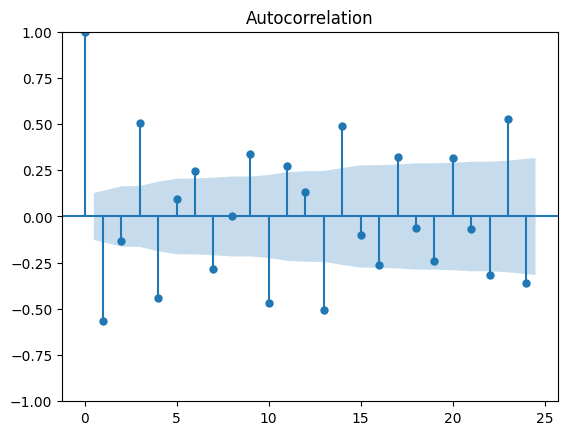

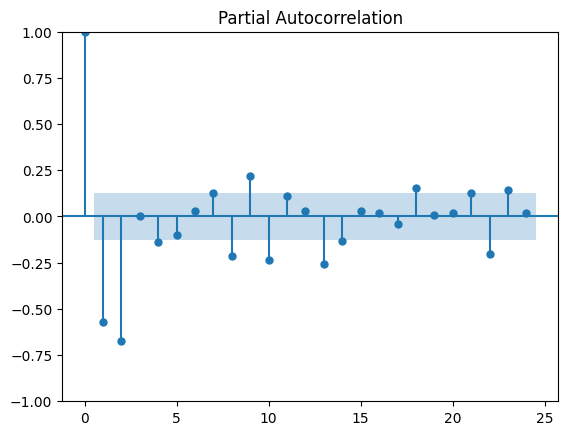

In [10]:
# <your_code_here>

# 1.
ts_log = np.log(ts)

# 2.
ts_flat = ts_log.diff().diff(12).dropna()
plot_acf(ts_flat);
plot_pacf(ts_flat);
d = 1
D = 1
# как мы видим модель четко разделима

# 3.
# Так как модель разделима, то там, где график корреляции не показывает резкого падения, параметры равны 0
# т.е. q, Q = 0
q = 0
Q = 0

# По графику частичной автокорреляции находим, что p = 2, P = 0
p = 2
P = 0

# 4. 
pdq = (2, 1, 0)
PDQ = (0, 1, 0, 12)

model = SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)
res = model.fit()
preds = res.forecast(69)
# восстановим в изначальном масштабе
plotting.plot_ts(np.exp(ts_log), ts_test, np.exp(preds))


#### Задание 3. (используя auto-arima)
1. Установить аналог auto-arima из R, библиотеку pmdarima (pip install pmdarima)
2. Обучить модель, используя функцию auto_arima, передав в нее нужные параметры.

In [11]:
# <your_code_here>
# наиболее удобная реализация AutoArima находится в модуле pmdarima
from pmdarima import auto_arima

# на вход подается ряд со всеми преобразованиями кроме дифференцирования, границы поиска параметров p, q, P, Q, 
# периодом сезонности m, параметрами дифференцирования d, D
model = auto_arima(
     ts_log, start_p=0, start_q=0,
     max_p=3, max_q=3, m=12,
     start_P=0, start_Q=0, seasonal=True,
     d=1, D=1, trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=True
)

# прогноз можем получить методом predict, указав горизонт прогнозирования
preds = model.predict(len(ts_test))

plotting.plot_ts(np.exp(ts_log), ts_test, pd.Series(np.exp(preds), index=ts_test.index))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-556.970, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-647.918, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-649.023, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-803.158, Time=0.10 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-806.341, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-823.880, Time=0.51 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-679.155, Time=0.51 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-822.275, Time=0.73 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-822.639, Time=0.89 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-

Loading BokehJS ...